In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../../..')
import mutagenesisfunctions as mf
import bpdev as bd
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import contacts

from Bio import AlignIO
import time as time
import pandas as pd
np.random.seed(42)

I want to make a figure that plots the normalized summary SoM score vs the normalized summary EC score. If the values track close to a line this would suggest that the models are performing similarly. 

A summary score is for each family. We will take the PPV at 0.7 of the number of expected cWW interactions for both models.

In [2]:
def compare_EC_summary(fam, ex, comp='cWW_int', min_dist=8.0):

    ######### EXTRACT DATA ###########

    #extract SoM results after an APC correction
    arrayspath = '../../marks/Arrays/%s_mlp_%s_red.npy'%(fam,numhidden)
    hol_mut2 = np.load(arrayspath)
    seqlen,_, dims,_ = hol_mut2.shape
    C = bd.get_wc(arrayspath, seqlen, dims, bpugSQ=0, denoise='APC')
    
    #Load in the EC annotation
    ECannotfile = '../../marks/%s/%s.EC.interaction.txt'%(fam,fam) 
    EC_df = pd.read_csv(ECannotfile, delimiter='\s+')

    ######### QUALITATIVE CONTACTS ###########

    #All cWW annotated interactions
    cWW_int = EC_df[EC_df['interactions'] == 'cWW']
    #All PDB contacts < 8 angstroms
    close_cont = EC_df[EC_df['minimum_atom_distance'] <= min_dist] 
    

    ######### QUANTITATIVE GRAPHS ###########

    #Get the real positive and negative pdb contacts
    def groundtruth(comp=comp):
        
        if comp == 'cWW_int':
            real_pos = np.zeros((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_pos[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 1.
            real_neg = np.ones((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_neg[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 0.
        return (real_pos, real_neg)
    
    real_pos, real_neg = groundtruth(comp=comp)
    
    def sumstats(thresh):
        #Get the top thresh SoM scores
        som_pos = bd.plot_wcrank(C, seqlen, thresh*2) #keeps *2 here because both triangles of C are still present
        som_pos[np.tril_indices(seqlen)] = 0.
        #Get the bottom thresh SoM scores
        som_neg = (~som_pos.astype('bool'))*1 #incantation converts binary to boolean, flips them then back to binary

        TP_som = np.sum(real_pos*som_pos)
        FP_som = np.sum(real_neg*som_pos)
        TN_som = np.sum(real_neg*som_neg)
        FN_som = np.sum(real_pos*som_neg)

        PPV_som = TP_som/(TP_som+FP_som)
        FDR_som = FP_som/(TP_som+FP_som)
        TPR_som = TP_som/(TP_som+FN_som)

        return (PPV_som)#)_som, FDR_som, TPR, TP, FP, TN, FN)

    def sumstats_EC(thresh):
        #Top thresh EC scores
        n_EC_P = len(EC_df.iloc[:thresh, :])
        EC_pos = np.zeros((seqlen,seqlen))
        for ii in range(n_EC_P):
            EC_pos[EC_df.iloc[ii, 1], EC_df.iloc[ii, 2]] = 1.
        EC_neg = np.ones((seqlen,seqlen))
        for ii in range(n_EC_P):
            EC_neg[EC_df.iloc[ii, 1], EC_df.iloc[ii, 2]] = 0.

        TP = np.sum(real_pos*EC_pos)
        FP = np.sum(real_neg*EC_pos)
        TN = np.sum(real_neg*EC_neg)
        FN = np.sum(real_pos*EC_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV)#, FDR, TPR, TP, FP, TN, FN)
    
    extent = int(len(cWW_int)*ex)
    
    return (sumstats(extent), sumstats_EC(extent))


In [3]:
#Load the SoM results file
families = ['RF00002', 'RF00005', 'RF00010', 'RF00017', 'RF00023', 'RF00050',
            'RF00059', 'RF00162', 'RF00167', 'RF00169', 'RF00174', 'RF00234',
            'RF00380', 'RF00504', 'RF01734', 'RF01786', 'RF01831', 'RF01852', 'RF02001']#, 'RF01960']

numhidden = 512

ex = np.linspace(0.2,1.0,5)

In [5]:
som_better = []
for e in ex:
    famsum = np.asarray([compare_EC_summary(fam, e) for fam in families])
    SoMsum = famsum[:, 0]
    ECsum = famsum[:, 1]
    r = SoMsum/ECsum
    b = len(np.where(r >=1)[0])
    som_better.append(b)
    
    

KeyboardInterrupt: 

In [6]:
famsum = np.asarray([compare_EC_summary(fam, 0.7) for fam in families])

In [7]:
SoMsum = famsum[:, 0]
ECsum = famsum[:, 1]
#normalize the scores
#SoMsum = SoMsum/np.max(SoMsum)
#ECsum = ECsum/np.max(ECsum)

d = {'Family':families, 'SoM summary': SoMsum, 'EC summary': ECsum}

#convert to a dataframe
sumdf = pd.DataFrame(d)

#import length info
infofile = '../../marks/marks_20_cutinfo.csv'
infodf = pd.read_csv(infofile)
#only get relevant families
inforel = infodf[[True if infodf.loc[ii, 'RFAM_ID'] in families else False for ii in infodf.index]]
inforel = inforel.set_index('RFAM_ID')

for ii in sumdf.index:
    sumdf.loc[ii, 'Length'] = inforel.loc[sumdf.loc[ii, 'Family'], 'Length']
    sumdf.loc[ii, 'M'] = inforel.loc[sumdf.loc[ii, 'Family'], 'M']
    sumdf.loc[ii, 'M_eff'] = inforel.loc[sumdf.loc[ii, 'Family'], 'M_eff']


/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


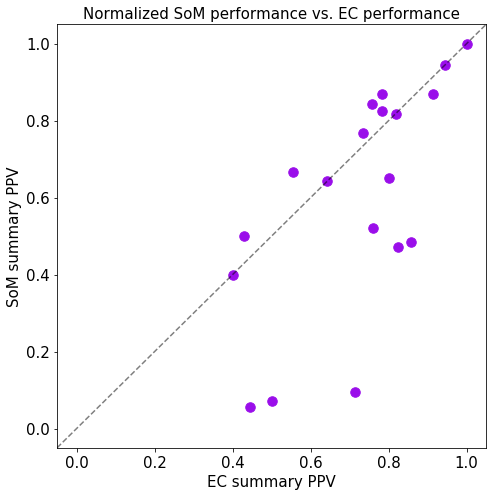

In [10]:
#order by var

fs = 15

xlims = [-0.05, 1.05]
ylims = [-0.05, 1.05]
plt.figure(figsize=(7,7))
plt.axis([xlims[0],xlims[1],ylims[0],ylims[1]])
plt.scatter(sumdf['EC summary'], sumdf['SoM summary'], c='xkcd:violet', s=90)
plt.plot(xlims,ylims, '--k', alpha=0.5)
plt.title('Normalized SoM performance vs. EC performance', fontsize=fs)
plt.xlabel('EC summary PPV', fontsize=fs)
plt.ylabel('SoM summary PPV', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.savefig('struc_sum.png')
plt.show()

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


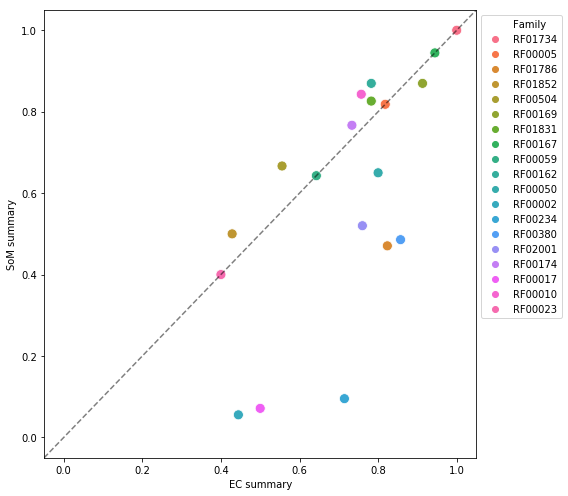

In [8]:
#order by var
var = 'Length'
xlims = [-0.05, 1.05]
ylims = [-0.05, 1.05]
plotdf = sumdf.sort_values(var)
plt.figure(figsize=(8,7))
plt.axis([xlims[0],xlims[1],ylims[0],ylims[1]])
ax = sb.scatterplot(data=plotdf, x='EC summary', y='SoM summary',
                    hue='Family', s=100)
plt.plot(xlims,ylims, '--k', alpha=0.5)
ax.legend(loc='best', bbox_to_anchor=(1., 1.))
plt.show()

In [12]:
sumdf['SoM:EC'] = sumdf['SoM summary']/sumdf['EC summary']

In [15]:
sumdf.sort_values('SoM:EC', ascending=False)

,Family,SoM summary,EC summary,Length,M,M_eff,SoM:EC
13,RF00504,0.666667,0.555556,91.0,6875.0,895.1,1.200000
17,RF01852,0.500000,0.428571,91.0,1959.0,157.2,1.166667
2,RF00010,0.842857,0.757143,359.0,6397.0,1215.1,1.113208
7,RF00162,0.869565,0.782609,108.0,4757.0,585.7,1.111111
16,RF01831,0.826087,0.782609,100.0,598.0,123.1,1.055556
10,RF00174,0.766667,0.733333,188.0,9056.0,3190.6,1.045455
4,RF00023,0.400000,0.400000,366.0,5983.0,1558.9,1.000000
6,RF00059,0.642857,0.642857,105.0,11197.0,2249.5,1.000000
8,RF00167,0.944444,0.944444,103.0,2427.0,471.1,1.000000
1,RF00005,0.818182,0.818182,73.0,298470.0,3533.2,1.000000
